VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h3>Import data</h3>

In [169]:
# We need to process both the training and test dataset the same way.
process_train = 0 # change toggle to 0 or 1 to process test or train
if process_train:
    filename = 'train.csv'
else:
    filename = 'test.csv'

In [170]:
df = pd.read_csv(filename, header=0)
#df.dtypes
#df.info()
#df.describe()
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


**Data Munging Tutorial**

In [171]:
# Obtain first 10 rows of Age column
df['Age'][0:10] 
df.Age[0:10]
# Get mean
df['Age'].mean()

# Obtain subsets 
df[['Sex', 'Pclass', 'Age']]

# Filtering
df[df['Age'] > 60]
df[df['Age'].isnull()]
print ''

**Feature Engineering**

In [172]:
#Create binary column with 1 if the name has parenthesis, 0 if it doesn't
#Looks like it's married women who have parenthesis (their original name)
def has_parenthesis(name):
    if '(' in name:
        return 1
    return 0
df['Parenthesis'] = df['Name'].map(has_parenthesis)

**Data Cleaning Tutorial**

In [173]:
# Binarize Sex column
df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [174]:
# Numerize Embarked column
df['Embarked_Num'] = df['Embarked'].map({'C':1, 'Q':2, 'S':3}).astype(float)

In [175]:
# Find median age of each class
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df[(df['Gender'] == i) & \
                              (df['Pclass'] == j+1)]['Age'].dropna().median()
# Fill in missing data with median age of each class
df['AgeFill'] = df['Age']
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]

df['AgeIsNull'] = pd.isnull(df.Age).astype(int)
df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill','AgeIsNull']].head(2)

,Gender,Pclass,Age,AgeFill,AgeIsNull
10,1,3,NaN,24,1
22,0,1,NaN,41,1


In [176]:
df.dtypes[df.dtypes.map(lambda x: x=='object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [177]:
# Drop columns with non-numeric values
df_new = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis=1)

In [178]:
df_new[df_new.isnull().any(axis=1)]

,PassengerId,Pclass,SibSp,Parch,Fare,Parenthesis,Gender,Embarked_Num,AgeFill,AgeIsNull
152,1044,3,0,0,NaN,0,1,3,60.5,0


In [179]:
# View rows with missing values
df_new[df_new.isnull().any(axis=1)]
# Drop rows with missing values
if process_train:
    df_new = df_new.dropna()
# Collect passenger ID before dropping from test dataset
if not process_train:
    ids = df_new['PassengerId'].values 
# Drop passenger ID and AgeIsNull
df_new = df_new.drop(['PassengerId','AgeIsNull'], axis=1)
df_new.head(2)

,Pclass,SibSp,Parch,Fare,Parenthesis,Gender,Embarked_Num,AgeFill
0,3,0,0,7.8292,0,1,2,34.5
1,3,1,0,7.0000,1,0,3,47.0


In [180]:
# Convert pandas table to array
if process_train:
    train_data = df_new.values
else:
    test_data = df_new.values
    feature_names = list(df_new.columns.values)

In [181]:
# Impute values for any missing values in test data, since we cannot drop observations in test data
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
test_data = imp.fit_transform(test_data)

<h3>Random Forest</h3>

A Random Forest is an ensemble of decision trees that output a prediction value (in our case, whether a passenger survives or not). Each decision tree is constructed with a random subset of the training data. 

In [137]:
from sklearn.ensemble import RandomForestClassifier
import csv as csv

In [138]:
# Create random forest object
forest = RandomForestClassifier(n_estimators = 100)

In [139]:
# Fit training data to survived labels and create decision trees
X = train_data[0::, 1::]
y = train_data[0::, 0]
forest = forest.fit(X, y)

In [140]:
# Run decision trees on test data
output = forest.predict(test_data).astype(int)

In [141]:
# Write predictons to file
predictions_file = open("mysecondforest.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Done.


<h3>Logistic Regression</h3>

Just trying out a different model for fun.
https://www.kaggle.com/c/titanic/forums/t/14919/my-titanic-survivor-in-r-diary

In [36]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
# This code is modified version of what I did in DIMACS
penalty_type = 'l1'
plot = False
regs = [10, 1.0, 0.01]
for reg in regs:
    logreg = linear_model.LogisticRegression(penalty = penalty_type, C=reg)
    logreg = logreg.fit(X, y)
    scores = cross_validation.cross_val_score(logreg, X, y, cv=5)
    mean_cv = sum(scores)/float(len(scores))
    print (reg, mean_cv)
    
    coef = abs(logreg.coef_)
    coef = [item for sublist in coef for item in sublist]
    coef_np = np.asarray(coef)
    top_coef = np.argsort(-coef_np)[:3]
    
    if plot:
        #Plot
        ind = np.arange(X.shape[1])  
        width = 0.35       
        fig, ax = plt.subplots()
        rects = ax.bar(ind, coef, width, color='gray')
        for index in top_coef:
            rects[index].set_color('b')
        plt.xticks(range(X.shape[1]))
        ax.set_xticklabels(feature_names,rotation=45)
        plt.suptitle("Feature Coefficients (%s, C=%s)" %(penalty_type,reg))
        ax.annotate('CV Score = %0.4f'%mean_cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                        xytext=(5, -5), textcoords='offset points',
                        ha='left', va='top')
        plt.show()

(10, 0.79754967307814384)
(1.0, 0.79643242556973282)
(0.01, 0.66930743350472921)


In [ ]:
logreg.predict(test_data).astype(int)

In [126]:
# Write predictons to file
predictions_file = open("logreg.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Done.


<h3>Gradient Boosting</h3>

Background reading:  
https://www.statsoft.com/Textbook/Boosting-Trees-Regression-Classification/button/1  
http://stats.stackexchange.com/questions/77018/random-forest-is-it-a-boosting-algorithm

In [183]:
from sklearn.ensemble import GradientBoostingClassifier
import csv as csv

(0.5, 0.82448927477017375)


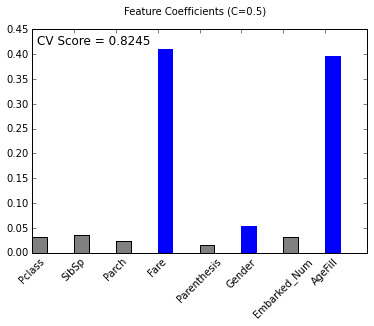

(0.2, 0.83126915219611841)


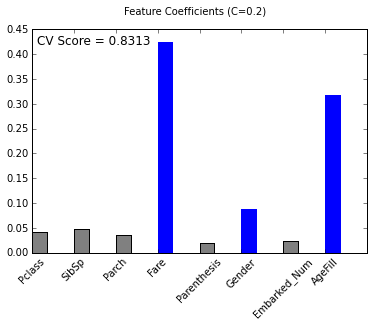

(0.1, 0.82341675178753826)


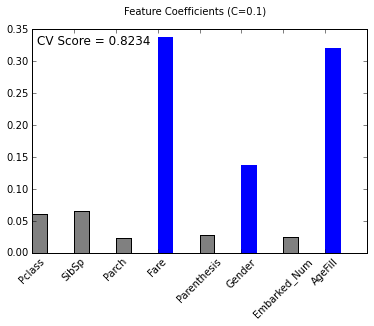

In [189]:
# Use cross-validation to select learning rate
# looks like best learning rate is the default value -_-
plot = True
rates = [0.5, 0.2, 0.1]
for r in rates:
    boost = GradientBoostingClassifier(n_estimators = 100, learning_rate = r)
    boost = boost.fit(X, y)
    scores = cross_validation.cross_val_score(boost, X, y, cv=10)
    mean_cv = sum(scores)/float(len(scores))
    print (r, mean_cv)
    
    coef = boost.feature_importances_
    coef_np = np.asarray(coef)
    top_coef = np.argsort(-coef_np)[:3]
    
    if plot:
        #Plot
        ind = np.arange(X.shape[1])  
        width = 0.35       
        fig, ax = plt.subplots()
        rects = ax.bar(ind, coef, width, color='gray')
        for index in top_coef:
            rects[index].set_color('b')
        plt.xticks(range(X.shape[1]))
        ax.set_xticklabels(feature_names,rotation=45)
        plt.suptitle("Feature Coefficients (C=%s)" %(r))
        ax.annotate('CV Score = %0.4f'%mean_cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                        xytext=(5, -5), textcoords='offset points',
                        ha='left', va='top')
        plt.show()

In [190]:
boost = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.2)
X = train_data[0::, 1::]
y = train_data[0::, 0]
boost = boost.fit(X, y)

In [191]:
output = boost.predict(test_data).astype(int)

In [192]:
# Write predictons to file
predictions_file = open("boosting.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Done.
